In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

Recebendo inputs do kaggle e separando em pastas

In [2]:
import os

# Caminhos para as pastas
train_color_dir = "/kaggle/working/train_color"
train_gray_dir = "/kaggle/working/train_gray"
val_color_dir = "/kaggle/working/val_color"
val_gray_dir = "/kaggle/working/val_gray"

# Função para criar pastas, se elas não existirem
def create_folders():
    os.makedirs(train_color_dir, exist_ok=True)
    os.makedirs(train_gray_dir, exist_ok=True)
    os.makedirs(val_color_dir, exist_ok=True)
    os.makedirs(val_gray_dir, exist_ok=True)

# Criar pastas
create_folders()

print("Pastas criadas com sucesso!")


Pastas criadas com sucesso!


In [3]:
import os
import shutil
from sklearn.model_selection import train_test_split

# Caminhos para as pastas
color_dir = "/kaggle/input/landscape-image-colorization/landscape Images/color"
gray_dir = "/kaggle/input/landscape-image-colorization/landscape Images/gray"
train_color_dir = "/kaggle/working/train_color"
train_gray_dir = "/kaggle/working/train_gray"
val_color_dir = "/kaggle/working/val_color"
val_gray_dir = "/kaggle/working/val_gray"

# Listar imagens (assumindo que os pares têm o mesmo nome de arquivo)
color_images = sorted(os.listdir(color_dir))
gray_images = sorted(os.listdir(gray_dir))

# Extraindo nomes dos arquivos (sem a extensão)
image_names = [os.path.splitext(img)[0] for img in color_images]

# Dividir em treino e validação (usando 20% para validação, por exemplo)
train_names, val_names = train_test_split(image_names, test_size=0.2, random_state=42)

# Função para mover arquivos
def copy_images(image_names, src_color_dir, src_gray_dir, dst_color_dir, dst_gray_dir):
    for name in image_names:
        shutil.copy(os.path.join(src_color_dir, f"{name}.jpg"), os.path.join(dst_color_dir, f"{name}.jpg"))
        shutil.copy(os.path.join(src_gray_dir, f"{name}.jpg"), os.path.join(dst_gray_dir, f"{name}.jpg"))

# Mover os arquivos
copy_images(train_names, color_dir, gray_dir, train_color_dir, train_gray_dir)
copy_images(val_names, color_dir, gray_dir, val_color_dir, val_gray_dir)

print("Imagens copiadas com sucesso!")


Imagens copiadas com sucesso!


Importando dependências

In [4]:
# Importe pacotes

import os
import cv2
import numpy as np
import pandas as pd
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import random
import shutil

Preparando imagens

In [5]:
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
from PIL import Image

# Definindo transformações para as imagens
transform = transforms.Compose([
    transforms.Resize((128, 128)),  # Redimensiona as imagens para um tamanho fixo
    transforms.ToTensor()  # Converte as imagens para tensores
])

# Classe customizada para carregar as imagens
class CustomDataset(Dataset):
    def __init__(self, gray_dir, color_dir, image_names, transform=None):
        self.gray_dir = gray_dir
        self.color_dir = color_dir
        self.image_names = image_names
        self.transform = transform

    def __len__(self):
        return len(self.image_names)

    def __getitem__(self, idx):
        gray_image_path = os.path.join(self.gray_dir, f"{self.image_names[idx]}.jpg")
        color_image_path = os.path.join(self.color_dir, f"{self.image_names[idx]}.jpg")

        gray_image = Image.open(gray_image_path).convert("L")
        color_image = Image.open(color_image_path).convert("RGB")

        if self.transform:
            gray_image = self.transform(gray_image)
            color_image = self.transform(color_image)

        return gray_image, color_image

# Criando datasets
train_dataset = CustomDataset(train_gray_dir, train_color_dir, train_names, transform=transform)
val_dataset = CustomDataset(val_gray_dir, val_color_dir, val_names, transform=transform)

# Criando DataLoaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=4, pin_memory=True)
#val_loader = DataLoader(val_dataset, batch_size=16, shuffle=True, num_workers=4, pin_memory=True)

print("DataLoaders criados com sucesso!")

DataLoaders criados com sucesso!


Definindo Gerador

In [6]:
# U-Net

import torch
import torch.nn as nn
import torch.nn.functional as F

class UNet(nn.Module):
    def __init__(self, image_dim, n_channels=64, depth=5, conv_kernel_size=3, conv_stride=1, conv_padding=1, pool_kernel_size=2, pool_stride=2, pool_padding=0, transpose_kernel_size=3, transpose_stride=2, transpose_padding=1):
        super(UNet, self).__init__()

        self.image_dim = image_dim  # Dimensões da imagem de entrada (C, H, W)
        self.depth = depth 
        self.n_channels = n_channels
        self.conv_kernel_size = conv_kernel_size
        self.conv_stride = conv_stride
        self.conv_padding = conv_padding
        self.pool_kernel_size = pool_kernel_size
        self.pool_stride = pool_stride
        self.pool_padding = pool_padding
        self.transpose_kernel_size = transpose_kernel_size
        self.transpose_stride = transpose_stride
        self.transpose_padding = transpose_padding
        
        # To RGB
        self.to_rgb = nn.Conv2d(1, 3, kernel_size=1)

        # Encoder
        self.encoders = nn.ModuleList([self.conv_block(3 if i == 0 else self.n_channels * (2 ** (i-1)), self.n_channels * (2 ** i)) for i in range(self.depth)])
        self.pool = nn.MaxPool2d(kernel_size=self.pool_kernel_size, stride=self.pool_stride, padding=self.pool_padding)

        # Bottleneck
        self.bottleneck = self.conv_block(self.n_channels * (2 ** (self.depth-1)), self.n_channels * (2 ** self.depth))

        # Decoder
        self.decoders = nn.ModuleList([self.conv_transpose(self.n_channels * (2 ** (i+2)), self.n_channels * (2 ** i)) for i in range(self.depth-2, -1, -1)])

        # Final conv layer
        self.final_conv = nn.Conv2d(self.n_channels, 3, kernel_size=1)

    def conv_block(self, in_channels, out_channels):
        # Camada convolucional com normalização e função de ativação; 2 vezes
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=self.conv_kernel_size, stride=self.conv_stride, padding=self.conv_padding),
            nn.BatchNorm2d(out_channels),  # Normalização para acelerar o treinamento
            nn.ReLU(inplace=True),  # Função de ativação (zera os valores negativos)
            nn.Conv2d(out_channels, out_channels, kernel_size=self.conv_kernel_size, stride=self.conv_stride, padding=self.conv_padding),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def crop(self, encoder_feature, decoder_feature):
        _, _, h, w = decoder_feature.size()
        encoder_feature = F.interpolate(encoder_feature, size=(h, w), mode='bilinear', align_corners=False)  # Redimensiona a feature map do encoder
        return encoder_feature

    def conv_transpose(self, in_channels, out_channels):
        return nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size=self.transpose_kernel_size, stride=self.transpose_stride, padding=self.transpose_padding),
            self.conv_block(out_channels, out_channels)
        )
    
    def forward(self, x):
        #print(f"Input shape: {x.shape}")
        encoders_features = []

        # RGB pass
        x = self.to_rgb(x)
        #print(f"After RGB pass: {x.shape}")

        # Encoder pass
        for idx, encoder in enumerate(self.encoders):
            #print("idx: ", idx)
            #print("encoder: ", encoder)
            x = encoder(x)
            encoders_features.append(x)
            #print(f"After encoder block {idx+1}: {x.shape}")
            x = self.pool(x)
            #print(f"After pooling {idx+1}: {x.shape}")

        # Bottleneck
        x = self.bottleneck(x)
        #print(f"After bottleneck: {x.shape}")
        # Doubled the block
        #print("Starting decoder pass")
        # Decoder pass
        for i, decoder in enumerate(self.decoders):
            #print("i: ", i)
            #print("decoder: ", decoder)
            encoder_feature = encoders_features[-(i+1)]
            encoder_feature = self.crop(encoder_feature, x)  # Aplica o crop nas feature maps
            #print(f"Encoder feature {i+1} after crop: {encoder_feature.shape}")

            if i != 0:
                x = torch.cat([encoder_feature, x], dim=1)  # Concatena encoder com decoder
                #print(f"After concatenation with encoder feature {i+1}: {x.shape}")

            x = decoder(x)

        # Final convolution
        x = self.final_conv(x)
        x = F.interpolate(x, size=(self.image_dim[2], self.image_dim[3]), mode='bilinear', align_corners=False)
        #print(f"Output shape after final convolution: {x.shape}")
        
        x = torch.sigmoid(x)
        
        return x

Testando gerador

In [7]:
"""# Obtendo as dimensões das imagens a partir do DataLoader
nex = next(iter(train_loader))
img_dim = nex[0].shape
label_dim = nex[1].shape
print("Img_dim: ", img_dim)
print("Label_dim: ", label_dim)
model = UNet(image_dim=img_dim, n_channels=64, depth=5, conv_kernel_size=3, conv_stride=1, conv_padding=1, pool_kernel_size=2, pool_stride=2, pool_padding=0, transpose_kernel_size=3, transpose_stride=2, transpose_padding=1)
# Configurando o dispositivo (GPU, se disponível)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Dispositivo: {device}")
model = model.to(device)  # Mover o modelo para o dispositivo


# Testando com um batch de dados do DataLoader
for images, labels in train_loader:
    # Move os dados para o dispositivo (GPU/CPU)
    images = images.to(device)
    labels = labels.to(device)
    print("Imagens e rótulos movidos para o dispositivo.")
    print(images.shape)
    print(labels.shape)
    print("Iniciando forward pass...")
    # Passa as imagens pelo modelo U-Net
    output = model(next(iter(train_loader))[0])
    
    # Exibe as dimensões das imagens, labels e da saída do modelo
    print(f"Imagens: {images.shape}")
    print(f"Labels: {labels.shape}")
    print(f"Saída do modelo: {output.shape}")
    
    # Quebrar após o primeiro batch, apenas para teste
    break"""

'# Obtendo as dimensões das imagens a partir do DataLoader\nnex = next(iter(train_loader))\nimg_dim = nex[0].shape\nlabel_dim = nex[1].shape\nprint("Img_dim: ", img_dim)\nprint("Label_dim: ", label_dim)\nmodel = UNet(image_dim=img_dim, n_channels=64, depth=5, conv_kernel_size=3, conv_stride=1, conv_padding=1, pool_kernel_size=2, pool_stride=2, pool_padding=0, transpose_kernel_size=3, transpose_stride=2, transpose_padding=1)\n# Configurando o dispositivo (GPU, se disponível)\ndevice = torch.device(\'cuda\' if torch.cuda.is_available() else \'cpu\')\nprint(f"Dispositivo: {device}")\nmodel = model.to(device)  # Mover o modelo para o dispositivo\n\n\n# Testando com um batch de dados do DataLoader\nfor images, labels in train_loader:\n    # Move os dados para o dispositivo (GPU/CPU)\n    images = images.to(device)\n    labels = labels.to(device)\n    print("Imagens e rótulos movidos para o dispositivo.")\n    print(images.shape)\n    print(labels.shape)\n    print("Iniciando forward pass...

Gerador gera uma imagem do tamanho desejado, passando pela unet

Discriminador

In [8]:

class Discriminator(nn.Module):
    def __init__(self, image_dim, n_channels=64, depth=5, conv_kernel_size=3, conv_stride=1, conv_padding=1, pool_kernel_size=2, pool_stride=2, pool_padding=0, transpose_kernel_size=3, transpose_stride=2, transpose_padding=1):
        super().__init__()

        self.image_dim = image_dim  # Dimensões da imagem de entrada (C, H, W)
        self.depth = depth 
        self.n_channels = n_channels
        self.conv_kernel_size = conv_kernel_size
        self.conv_stride = conv_stride
        self.conv_padding = conv_padding
        self.pool_kernel_size = pool_kernel_size
        self.pool_stride = pool_stride
        self.pool_padding = pool_padding
        self.transpose_kernel_size = transpose_kernel_size
        self.transpose_stride = transpose_stride
        self.transpose_padding = transpose_padding

        # Encoder
        self.encoders = nn.ModuleList([self.conv_block(3 if i == 0 else self.n_channels * (2 ** (i-1)), self.n_channels * (2 ** i)) for i in range(self.depth)])
        self.pool = nn.MaxPool2d(kernel_size=self.pool_kernel_size, stride=self.pool_stride, padding=self.pool_padding)

        # Bottleneck
        self.bottleneck = self.conv_block(self.n_channels * (2 ** (self.depth-1)), self.n_channels * (2 ** self.depth))

        # Final conv layer
        self.final_conv = nn.Conv2d(self.n_channels * (2 ** self.depth), 1, kernel_size=1)

        # Fully connected layer to reduce the dimensions to [32, 1, 1, 1]
        self.fc = nn.Linear(self.image_dim[2] * self.image_dim[3], 1)

    def conv_block(self, in_channels, out_channels):
        # Camada convolucional com normalização e função de ativação; 2 vezes
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=self.conv_kernel_size, stride=self.conv_stride, padding=self.conv_padding),
            nn.BatchNorm2d(out_channels),  # Normalização para acelerar o treinamento
            nn.ReLU(inplace=True),  # Função de ativação (zera os valores negativos)
            nn.Conv2d(out_channels, out_channels, kernel_size=self.conv_kernel_size, stride=self.conv_stride, padding=self.conv_padding),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def crop(self, encoder_feature, decoder_feature):
        _, _, h, w = decoder_feature.size()
        encoder_feature = F.interpolate(encoder_feature, size=(h, w), mode='bilinear', align_corners=False)  # Redimensiona a feature map do encoder
        return encoder_feature

    def conv_transpose(self, in_channels, out_channels):
        return nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size=self.transpose_kernel_size, stride=self.transpose_stride, padding=self.transpose_padding),
            self.conv_block(out_channels, out_channels)
        )
    
    def forward(self, x):
        #print(f"Input shape: {x.shape}")
        encoders_features = []

        # Encoder pass
        for idx, encoder in enumerate(self.encoders):
            #print("idx: ", idx)
            #print("encoder: ", encoder)
            x = encoder(x)
            encoders_features.append(x)
            #print(f"After encoder block {idx+1}: {x.shape}")
            x = self.pool(x)
            #print(f"After pooling {idx+1}: {x.shape}")

        # Bottleneck
        x = self.bottleneck(x)
        #print(f"After bottleneck: {x.shape}")
        # Doubled the block
        #print("Starting decoder pass")

        # Final convolution
        x = self.final_conv(x)
        x = F.interpolate(x, size=(1, 1), mode='bilinear', align_corners=False)
        #print(f"Output shape after final convolution: {x.shape}")
        x = torch.sigmoid(x)


        return x

In [9]:
"""# Obtendo as dimensões das imagens a partir do DataLoader
nex = next(iter(train_loader))
img_dim = nex[0].shape
label_dim = nex[1].shape
print("Img_dim: ", img_dim)
print("Label_dim: ", label_dim)
disc = Discriminator(image_dim=img_dim, n_channels=64, depth=5, conv_kernel_size=3, conv_stride=1, conv_padding=1, pool_kernel_size=2, pool_stride=2, pool_padding=0, transpose_kernel_size=3, transpose_stride=2, transpose_padding=1)
# Configurando o dispositivo (GPU, se disponível)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Dispositivo: {device}")
disc = disc.to(device)  # Mover o modelo para o dispositivo


# Testando com um batch de dados do DataLoader
for images, labels in train_loader:
    # Move os dados para o dispositivo (GPU/CPU)
    images = images.to(device)
    labels = labels.to(device)
    print("Imagens e rótulos movidos para o dispositivo.")
    print(images.shape)
    print(labels.shape)
    print("Iniciando forward pass...")
    # Passa as imagens pelo modelo U-Net
    output = disc(next(iter(train_loader))[1])
    
    # Exibe as dimensões das imagens, labels e da saída do modelo
    print(f"Imagens: {images.shape}")
    print(f"Labels: {labels.shape}")
    print(f"Saída do modelo: ", output.shape)
    
    # Quebrar após o primeiro batch, apenas para teste
    break"""

'# Obtendo as dimensões das imagens a partir do DataLoader\nnex = next(iter(train_loader))\nimg_dim = nex[0].shape\nlabel_dim = nex[1].shape\nprint("Img_dim: ", img_dim)\nprint("Label_dim: ", label_dim)\ndisc = Discriminator(image_dim=img_dim, n_channels=64, depth=5, conv_kernel_size=3, conv_stride=1, conv_padding=1, pool_kernel_size=2, pool_stride=2, pool_padding=0, transpose_kernel_size=3, transpose_stride=2, transpose_padding=1)\n# Configurando o dispositivo (GPU, se disponível)\ndevice = torch.device(\'cuda\' if torch.cuda.is_available() else \'cpu\')\nprint(f"Dispositivo: {device}")\ndisc = disc.to(device)  # Mover o modelo para o dispositivo\n\n\n# Testando com um batch de dados do DataLoader\nfor images, labels in train_loader:\n    # Move os dados para o dispositivo (GPU/CPU)\n    images = images.to(device)\n    labels = labels.to(device)\n    print("Imagens e rótulos movidos para o dispositivo.")\n    print(images.shape)\n    print(labels.shape)\n    print("Iniciando forward p

Treino

In [10]:
from torch.optim import Adam
from torch.nn import BCELoss, L1Loss
import time

# Loss para o discriminador
d_loss = BCELoss()

class GeneratorLoss(nn.Module):
    def __init__(self, lambda_l1=100):
        super(GeneratorLoss, self).__init__()
        # Definir a perda BCE (usada para a parte adversária)
        self.adversarial_loss = nn.BCELoss()
        # Definir a perda L1
        self.l1_loss = nn.L1Loss()
        # Peso da perda L1
        self.lambda_l1 = lambda_l1

    def forward(self, yhat_fake, fake_images, real_images):
        """
        Parâmetros:
        - yhat_fake: As previsões do discriminador sobre as imagens geradas (fake)
        - fake_images: Imagens geradas pelo gerador
        - real_images: Imagens reais de referência
        
        Retorna:
        - A perda total combinando perda adversária e L1
        """
        # Perda adversária: tentar fazer o discriminador acreditar que as imagens geradas são reais
        adversarial_loss = self.adversarial_loss(yhat_fake, torch.ones_like(yhat_fake))
        
        # Perda L1: minimizar a diferença entre as imagens geradas e as reais
        l1_loss = self.l1_loss(fake_images, real_images)
        
        # Perda total: adversária + ponderação da perda L1
        total_loss = adversarial_loss + self.lambda_l1 * l1_loss
        
        return total_loss

g_loss = GeneratorLoss()

# Normalize the input values to be between 0 and 1
def normalize(tensor):
    return (tensor - tensor.min()) / (tensor.max() - tensor.min())


In [11]:
class PaisagemGAN(nn.Module):
    def __init__(self, generator, discriminator):
        super(PaisagemGAN, self).__init__()
        self.generator = generator
        self.discriminator = discriminator
        self.global_step = 0

    def compile(self, g_loss, d_loss):
        self.g_loss = g_loss
        self.d_loss = d_loss
        self.g_opt = Adam(self.generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
        self.d_opt = Adam(self.discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))

    def train_step(self, real_images, grey_images):
        
        # Train the discriminator
        #inicio = time.time()
        self.d_opt.zero_grad()
        
        fake_images = self.generator(grey_images)
        yhat_real = self.discriminator(real_images)
        yhat_fake = self.discriminator(fake_images)
        
        d_loss_real = self.d_loss(yhat_real, torch.ones_like(yhat_real))
        d_loss_fake = self.d_loss(yhat_fake, torch.zeros_like(yhat_fake))
        total_d_loss = d_loss_real + d_loss_fake
        total_d_loss.backward()
        
        # Update discriminator weights every 5 steps
        if self.global_step % 5 == 0:
            self.d_opt.step()
        
        self.global_step += 1
        #fim = time.time()
        #print(fim - inicio)

        # Train the generator
        #inicio = time.time()
        self.g_opt.zero_grad()
        
        fake_images = self.generator(grey_images)
        yhat_fake = self.discriminator(fake_images)
        total_g_loss = self.g_loss(yhat_fake, fake_images, real_images)
        
        total_g_loss.backward()
        self.g_opt.step()
        #fim = time.time()
        #print(fim - inicio)
        
        return {'d_loss': total_d_loss.item(), 'g_loss': total_g_loss.item(), 'gen': fake_images}

Realizar treinamento

In [12]:
nex = next(iter(train_loader))
img_dim = nex[0].shape

gene = UNet(image_dim=img_dim, n_channels=64, depth=5, conv_kernel_size=3, conv_stride=1, conv_padding=1, pool_kernel_size=2, pool_stride=2, pool_padding=0, transpose_kernel_size=3, transpose_stride=2, transpose_padding=1)
# Configurando o dispositivo (GPU, se disponível)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Dispositivo: {device}")
gene = gene.to(device)  # Mover o modelo para o dispositivo

disc = Discriminator(image_dim=img_dim, n_channels=64, depth=5, conv_kernel_size=3, conv_stride=1, conv_padding=1, pool_kernel_size=2, pool_stride=2, pool_padding=0, transpose_kernel_size=3, transpose_stride=2, transpose_padding=1)
# Configurando o dispositivo (GPU, se disponível)
#device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Dispositivo: {device}")
disc = disc.to(device)  # Mover o modelo para o dispositivo

Dispositivo: cuda
Dispositivo: cuda


In [13]:
def save_checkpoint(model, optimizer, epoch, batch, loss, filepath='checkpoint.pth'):
    checkpoint = {
        'epoch': epoch,
        'batch': batch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss
    }
    torch.save(checkpoint, filepath)

Iniciar treinamento

Epoch [1/101], d_loss: 1.2890, g_loss: 9.1713
135.45941996574402


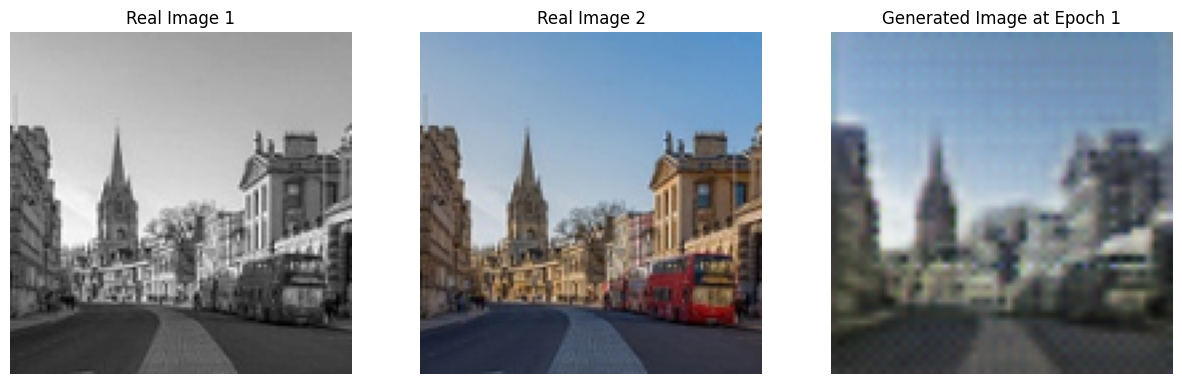


Epoch [2/101], d_loss: 0.3780, g_loss: 11.4749
134.32970595359802

Epoch [3/101], d_loss: 0.6070, g_loss: 14.9517
134.34776282310486

Epoch [4/101], d_loss: 0.6455, g_loss: 10.0540
134.32754826545715

Epoch [5/101], d_loss: 1.4874, g_loss: 10.2708
134.3166787624359


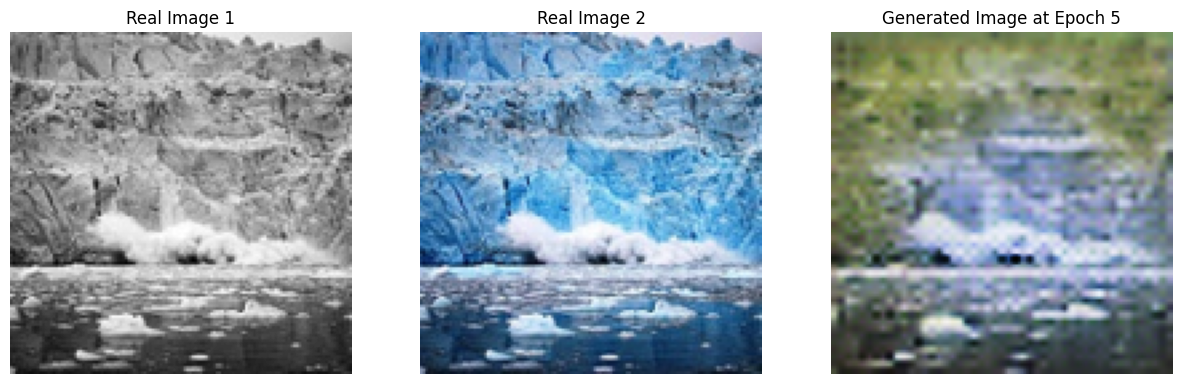


Epoch [6/101], d_loss: 1.4370, g_loss: 12.3447
134.35015034675598

Epoch [7/101], d_loss: 0.7949, g_loss: 10.3995
134.31858325004578

Epoch [8/101], d_loss: 0.0511, g_loss: 10.6771
134.31576490402222

Epoch [9/101], d_loss: 0.0876, g_loss: 13.5053
134.3434181213379

Epoch [10/101], d_loss: 0.0053, g_loss: 13.0348
134.3299696445465


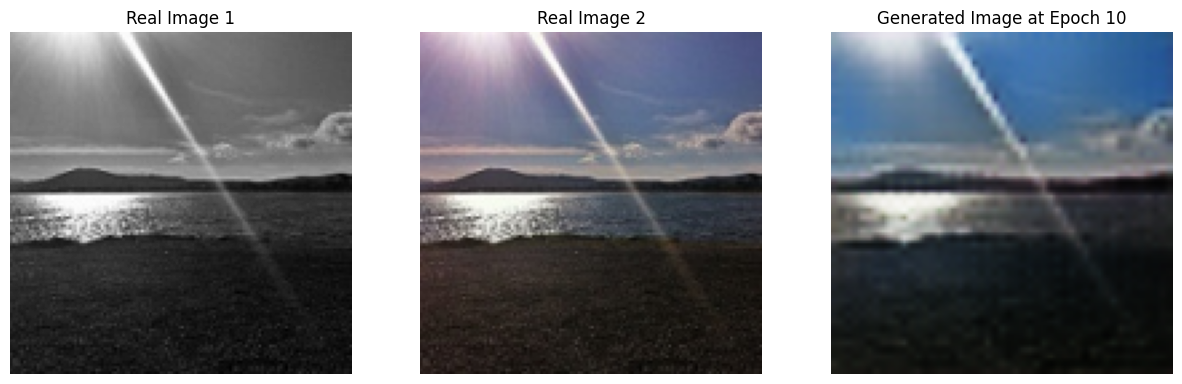


Epoch [11/101], d_loss: 0.0132, g_loss: 12.1127
134.33560609817505

Epoch [12/101], d_loss: 0.0044, g_loss: 13.0387
134.30146193504333

Epoch [13/101], d_loss: 0.5475, g_loss: 13.6225
134.35830545425415

Epoch [14/101], d_loss: 1.0014, g_loss: 15.1388
134.29580950737

Epoch [15/101], d_loss: 0.3904, g_loss: 9.3490
134.31215524673462


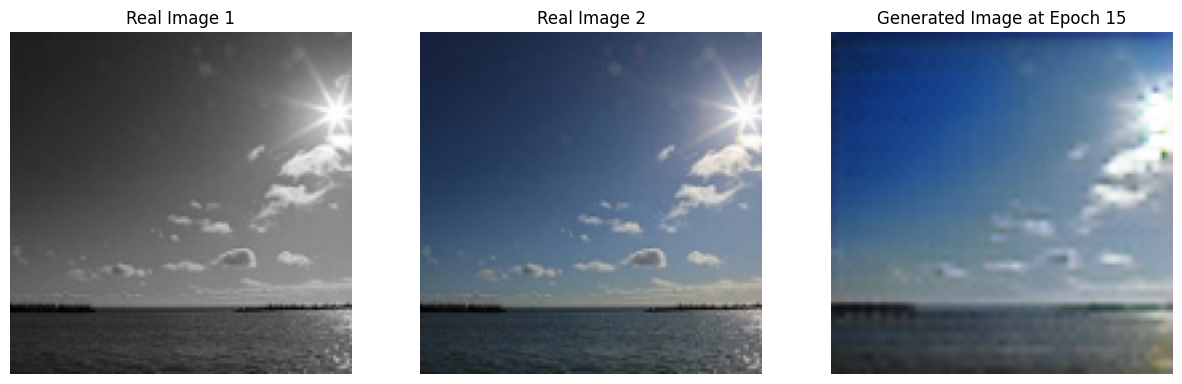


Epoch [16/101], d_loss: 1.2846, g_loss: 9.8100
134.3207767009735

Epoch [17/101], d_loss: 0.1430, g_loss: 11.0848
134.30927300453186

Epoch [18/101], d_loss: 0.0032, g_loss: 13.9656
134.32098722457886

Epoch [19/101], d_loss: 0.0942, g_loss: 11.8925
134.33098316192627

Epoch [20/101], d_loss: 0.0035, g_loss: 15.7835
134.27809119224548


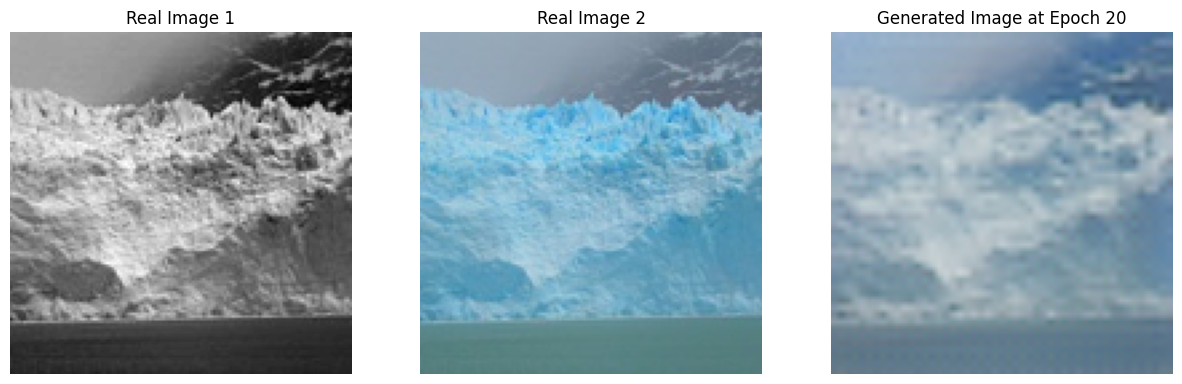


Epoch [21/101], d_loss: 0.0013, g_loss: 14.3809
134.29389834403992

Epoch [22/101], d_loss: 0.0008, g_loss: 13.9036
134.27057003974915

Epoch [23/101], d_loss: 0.0007, g_loss: 17.3783
134.1997730731964

Epoch [24/101], d_loss: 0.0007, g_loss: 15.7468
134.2001988887787

Epoch [25/101], d_loss: 0.0007, g_loss: 14.1075
134.20364665985107


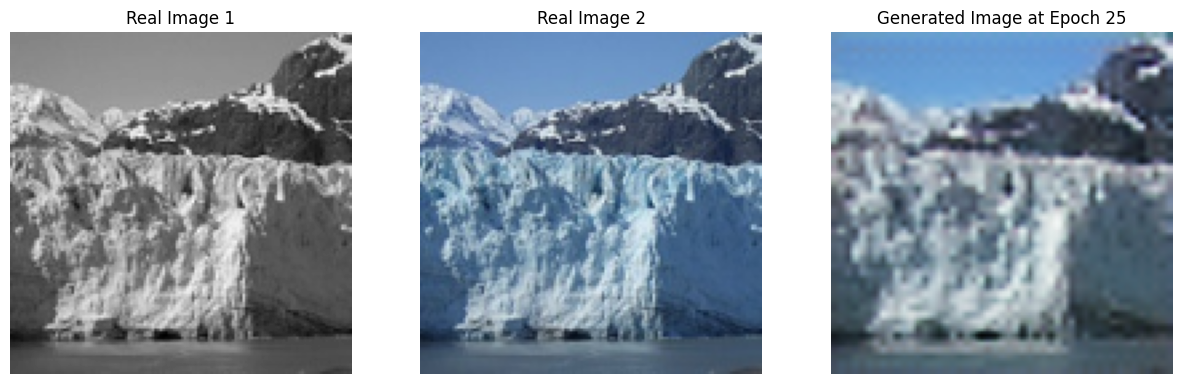


Epoch [26/101], d_loss: 0.0012, g_loss: 15.2301
134.29108333587646

Epoch [27/101], d_loss: 0.0004, g_loss: 14.7128
134.2943902015686

Epoch [28/101], d_loss: 0.0006, g_loss: 16.5081
134.28171277046204

Epoch [29/101], d_loss: 0.0004, g_loss: 16.2321
134.28927755355835

Epoch [30/101], d_loss: 0.0003, g_loss: 15.7531
134.29318356513977


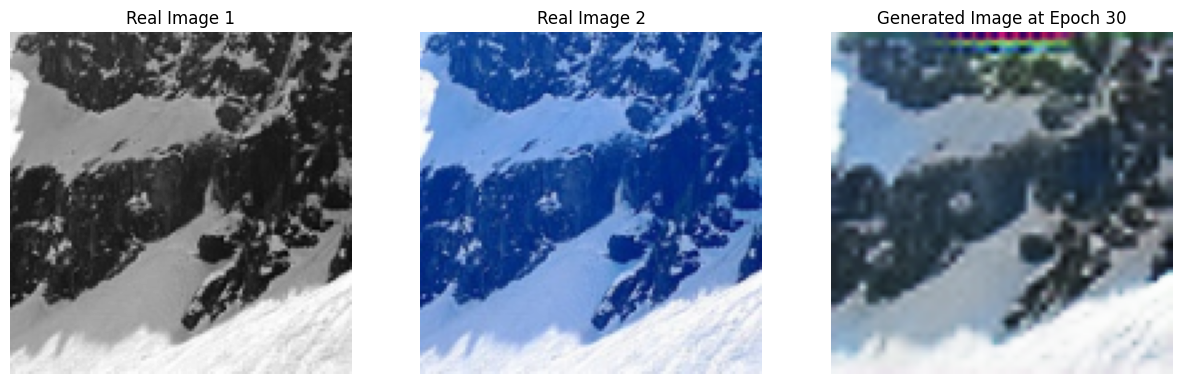


Epoch [31/101], d_loss: 0.0003, g_loss: 15.0819
134.30542635917664

Epoch [32/101], d_loss: 0.0003, g_loss: 14.5345
134.25548219680786

Epoch [33/101], d_loss: 0.0002, g_loss: 14.1626
134.3018102645874

Epoch [34/101], d_loss: 0.0002, g_loss: 16.4099
134.28099370002747

Epoch [35/101], d_loss: 0.0002, g_loss: 15.3313
134.21481728553772


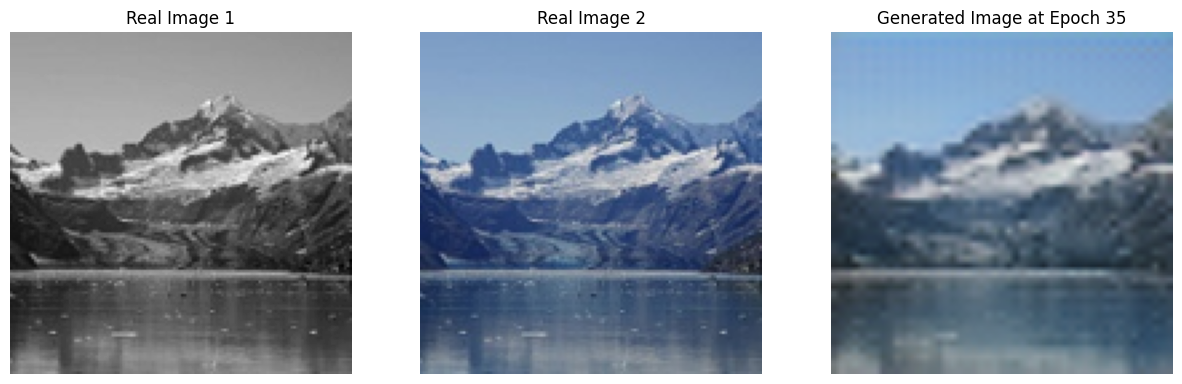


Epoch [36/101], d_loss: 0.0002, g_loss: 14.7160
134.18614435195923

Epoch [37/101], d_loss: 0.0002, g_loss: 14.9183
134.20707249641418

Epoch [38/101], d_loss: 0.0002, g_loss: 16.3175
134.31017971038818

Epoch [39/101], d_loss: 0.0001, g_loss: 18.4795
134.27172756195068

Epoch [40/101], d_loss: 0.0001, g_loss: 15.5439
134.25170254707336


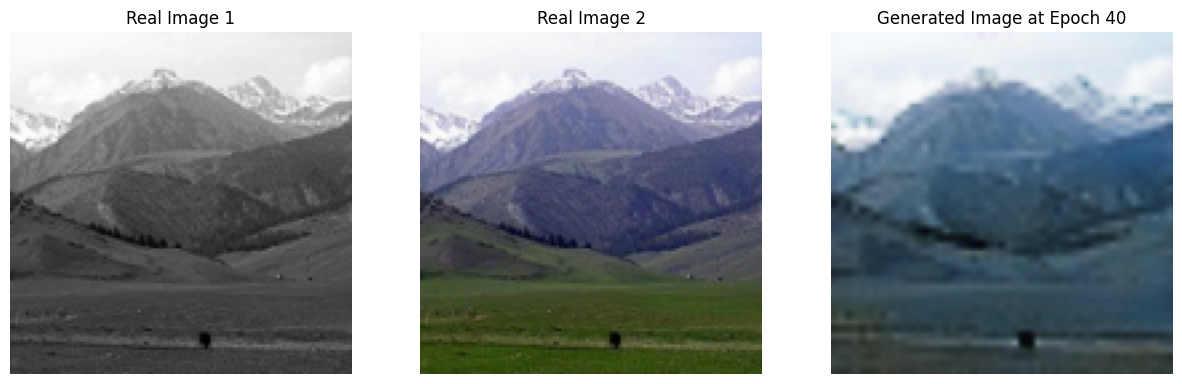


Epoch [41/101], d_loss: 0.0002, g_loss: 14.5669
134.31780624389648

Epoch [42/101], d_loss: 0.0001, g_loss: 14.3817
134.27866315841675

Epoch [43/101], d_loss: 0.0002, g_loss: 14.4908
134.29609155654907

Epoch [44/101], d_loss: 0.0005, g_loss: 15.8251
134.26343894004822


In [ ]:
from matplotlib import pyplot as plt

# Instanciando o modelo GAN
gan = PaisagemGAN(generator=gene, discriminator=disc)
gan = gan.to(device)
gan.compile(g_loss=g_loss, d_loss=d_loss)

# Número de épocas
num_epochs = 101


# Loop de treinamento
print("Iniciar treinamento")
for epoch in range(num_epochs):
    i = 0
    inicio = time.time()
    for batch in train_loader:
        #if i >= 4:
        #    break
        # Normalizando os valores dos batches
        #batch = (batch[0] / 255.0, batch[1] / 255.0)
        real_images = normalize(batch[1].to(device))
        grey_images = normalize(batch[0].to(device))
        loss = gan.train_step(real_images, grey_images)
        #print("|", end="")
        i += 1
        real_images.cpu()
        grey_images.cpu()
    print("")
    print(f"Epoch [{epoch+1}/{num_epochs}], d_loss: {loss['d_loss']:.4f}, g_loss: {loss['g_loss']:.4f}")
    fim = time.time()
    print(fim - inicio)

    if (epoch+1) % 5 == 0 or (epoch) == 0:
        save_checkpoint(gan.generator, gan.g_opt, epoch, batch, loss, filepath='/kaggle/working/gen.pth')
        save_checkpoint(gan.discriminator, gan.d_opt, epoch, batch, loss, filepath='/kaggle/working/disc.pth')
        # Convertendo as imagens geradas de 0-1 para 0-255
        gen_image = (loss['gen'][0].detach().cpu().numpy().transpose(1, 2, 0) * 255).astype('uint8')

        # Convertendo batch[0] e batch[1] de 0-1 para 0-255
        real_image1 = (batch[0][0].detach().cpu().numpy().squeeze()*255).astype('uint8')
        real_image2 = (batch[1][0].detach().cpu().numpy().transpose(1, 2, 0)*255 ).astype('uint8')

        # Plotando as três imagens lado a lado
        fig, axes = plt.subplots(1, 3, figsize=(15, 5))

        axes[0].imshow(real_image1, cmap='gray')
        axes[0].set_title("Real Image 1")

        axes[1].imshow(real_image2)
        axes[1].set_title("Real Image 2")

        axes[2].imshow(gen_image)
        axes[2].set_title(f"Generated Image at Epoch {epoch + 1}")

        for ax in axes:
            ax.axis('off')  # Remove os eixos

        plt.show()

print("Treinamento concluído!")


In [ ]:
#torch.cuda.empty_cache()
